In [2]:
import pandas as pd, pyarrow
from pathlib import Path
from sympy import init_printing
init_printing()
import numpy as np

In [3]:
RAW_PATH = Path("/Users/angryissues/python_projects/ML/data/raw/News_Category_Dataset_v3.json")
df = pd.read_json(RAW_PATH, lines=True)

df["text"] = df["headline"] + " " + df["short_description"]
df[["category", "text", "date"]].head()

,category,text,date
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-23
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",2022-09-23
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-23
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,2022-09-23
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-22


In [4]:
df["date"] = pd.to_datetime(df["date"])

In [5]:
import nltk, json
from nltk.corpus import stopwords

In [6]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

CUSTOM_STOP = {"u", "us", "’s", "“", "”", "–", "…"}
STOPWORDS.update(CUSTOM_STOP)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angryissues/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re, emoji, spacy
from string import punctuation
from pathlib import Path

In [8]:
NLP = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [9]:
URL_RE   = re.compile(r"https?://\S+|www\.\S+")
HTML_RE  = re.compile(r"<.*?>")
NUM_RE   = re.compile(r"\d+")
PUNCT_TBL = str.maketrans("", "", punctuation)

In [10]:
def clean_text(text: str) -> list[str]:
    text = text.lower()                    # 1) lowercase
    text = URL_RE.sub(" ", text)           # 2) remove urls
    text = HTML_RE.sub(" ", text)          # 3) strip html tags
    text = emoji.replace_emoji(text, " ")  # 4) drop emoji
    text = NUM_RE.sub(" ", text)           # 5) drop pure numbers
    text = text.translate(PUNCT_TBL)       # 6) drop punctuation

    doc = NLP(text)                        # 7) tokenize & lemmatize
    tokens = [
        tok.lemma_ for tok in doc
        if tok.is_alpha                  # только буквенные
        and tok.lemma_ not in STOPWORDS  # не стоп-слова
        and len(tok) > 2                 # длина ≥ 3 символа
    ]
    return tokens

In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df["tokens"] = df["text"].progress_apply(clean_text)

100%|██████████| 209527/209527 [06:42<00:00, 520.80it/s]


Промежуточный результат

In [13]:
df[["headline", "tokens"]].head(4)

,headline,tokens
0,Over 4 Million Americans Roll Up Sleeves For O...,"[million, americans, roll, sleeve, omicrontarg..."
1,"American Airlines Flyer Charged, Banned For Li...","[american, airlines, flyer, charge, ban, life,..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,"[funniest, tweet, cat, dog, week, sept, dog, u..."
3,The Funniest Tweets From Parents This Week (Se...,"[funniest, tweet, parent, week, sept, accident..."


In [14]:
PROCESSED = Path("data/raw/news_tokens.parquet")
df[["category", "date", "tokens"]].to_parquet(PROCESSED, index=False)

In [15]:
# Сколько слов в словаре
vocab = {tok for row in df["tokens"] for tok in row}
print("Vocabulary size:", len(vocab))

Vocabulary size: 94238


In [16]:
# Средняя длина документа
print("Avg tokens per doc:", df["tokens"].str.len().mean())

Avg tokens per doc: 16.89762178621371


# Дескриптивная статистика и визуализации

In [17]:
# Базовая сводка корпуса
docs   = len(df)
tokens = df["tokens"].explode()
vocab  = tokens.nunique()
ttr    = vocab / tokens.size
hapax  = (tokens.value_counts() == 1).mean() * 100

print(f"Документов     : {docs:,}")
print(f"Всех токенов   : {tokens.size:,}")
print(f"Уникальных слов: {vocab:,}")
print(f"TTR            : {ttr:.3f}")
print(f"Hapax %        : {hapax:.1f}%")

Документов     : 209,527
Всех токенов   : 3,540,528
Уникальных слов: 94,238
TTR            : 0.027
Hapax %        : 48.6%


In [18]:
# Частотные таблицы
TOP_K = 30

# все слова
freq_all = tokens.value_counts().head(TOP_K)

# по категориям ─ словарь {cat: Series}
freq_cat = (
    df.explode("tokens")
      .groupby("category")["tokens"]
      .value_counts()
      .groupby(level=0)
      .head(TOP_K)
      .reset_index(name="freq")
)

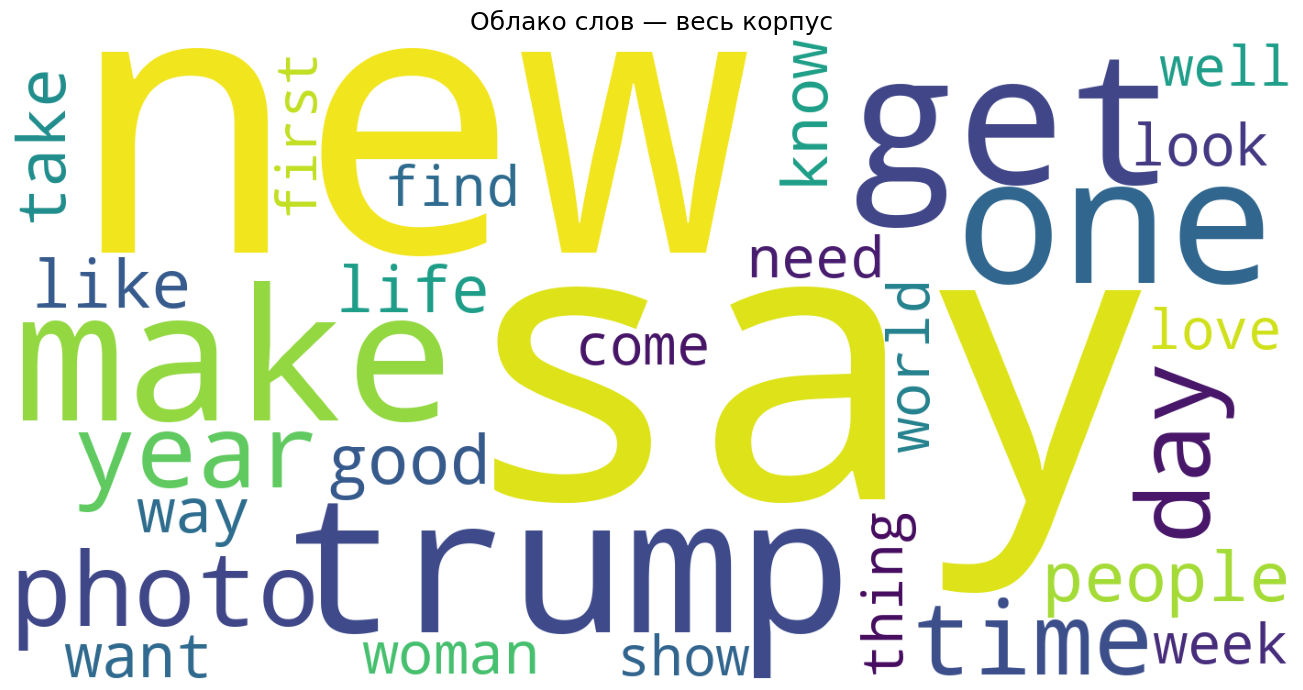

In [19]:
#  WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=1400, height=700,
               background_color="white",
               collocations=False)       # чтобы биграммы не склеивало

plt.figure(figsize=(14,7))
plt.imshow(wc.generate_from_frequencies(freq_all.to_dict()))
plt.axis("off")
plt.title("Облако слов — весь корпус", size=18)
plt.tight_layout(); plt.show()

Лидер частоты — say, за ним new, trump, make, get, one и т.д.

Перед обучением моделей стоит дополнительно отфильтровать «полуустойчивые» стоп‑слова (say, make, get, one).

Популярность trump и photo указывает на значительный пласт политических и развлекательных новостей.

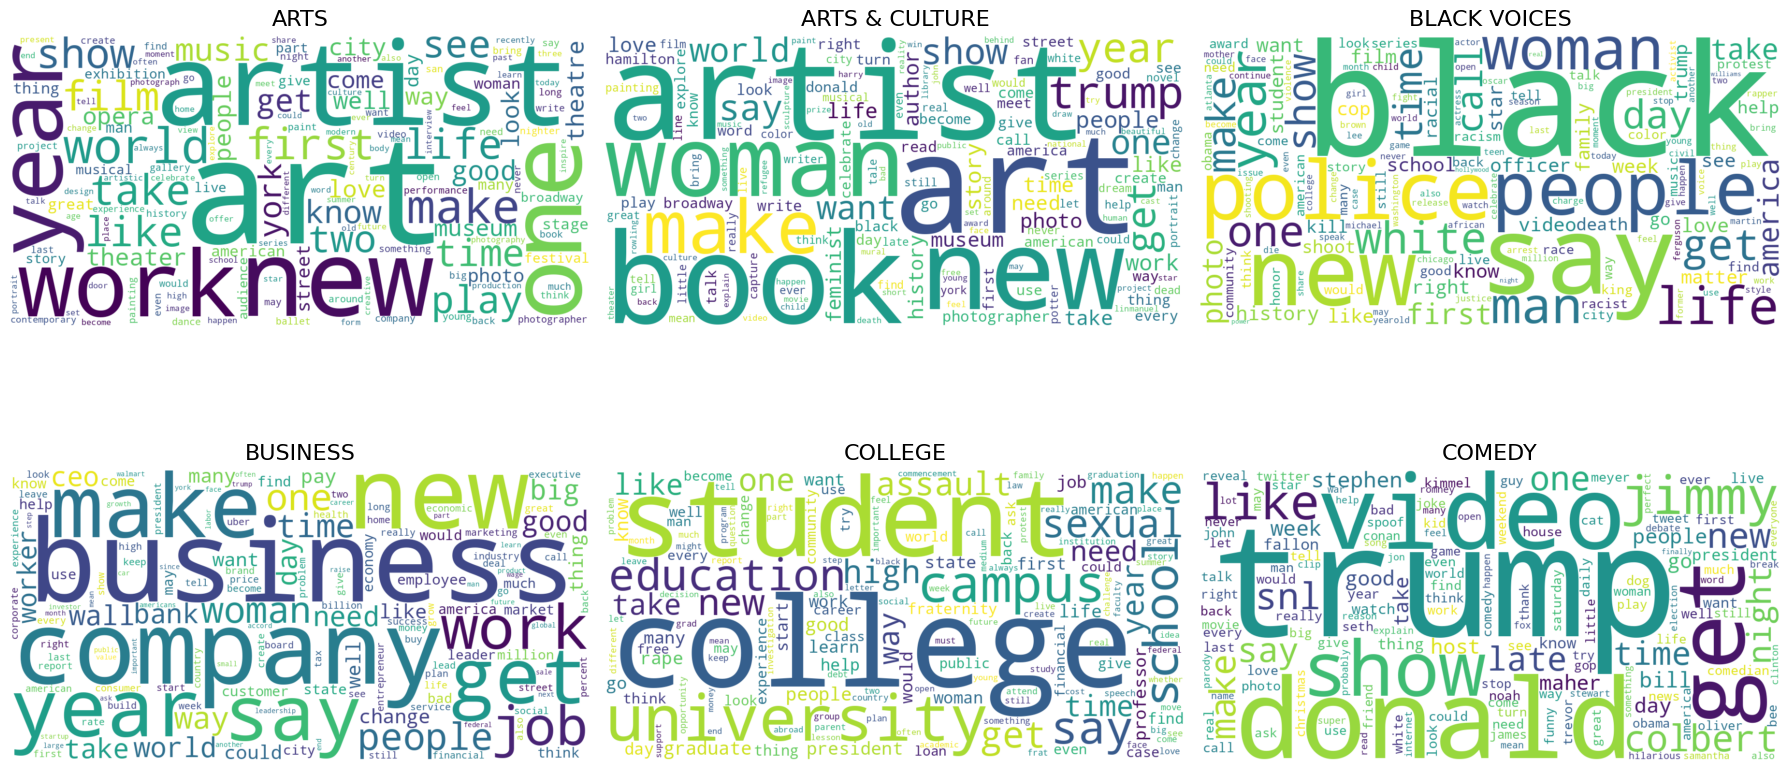

In [20]:
# По категориям
TOP_N = 150          # сколько слов берём для облака

freq_cat = (
    df.explode("tokens")
      .groupby("category")["tokens"]
      .value_counts()
      .groupby(level=0)
      .head(TOP_N)                    # top-N внутри каждой категории
      .reset_index(name="freq")
)

# 2. список уникальных категорий (можно отсортировать по алфавиту)
cats = sorted(freq_cat["category"].unique())

# 3. создаём выходную папку
out_dir = Path("figures/wordclouds")
out_dir.mkdir(parents=True, exist_ok=True)

# 4. строим на сетке 2 × 3 (подойдёт для 6 категорий; измените при желании)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

wc = WordCloud(width=1200, height=600,
               background_color="white",
               collocations=False)

for ax, cat in zip(axes.flatten(), cats):
    grp = freq_cat[freq_cat["category"] == cat]
    freq_dict = dict(zip(grp["tokens"], grp["freq"]))
    img = wc.generate_from_frequencies(freq_dict)

    ax.imshow(img, interpolation="bilinear")
    ax.set_title(cat, fontsize=16, pad=8)
    ax.axis("off")

    # (опц.) сохранить отдельный файл
    img.to_file(out_dir / f"{cat}_wordcloud.png")

plt.tight_layout()
plt.show()

• ARTS / ARTS & CULTURE — доминируют artist, art, book, feminist.
• BLACK VOICES — black, police, white, year, people → фокус на расовой повестке и правоохранительных темах.
• BUSINESS — company, business, job, make — корпоративная лексика.
• COLLEGE — student, university, sexual, campus — студенческая и #MeToo‑повестка.
• COMEDY — trump, video, show, donald, colbert — привязка к политической сатире.

Слова действительно отражают тематику рубрик → модель классификации сможет опираться на ключевую лексику.

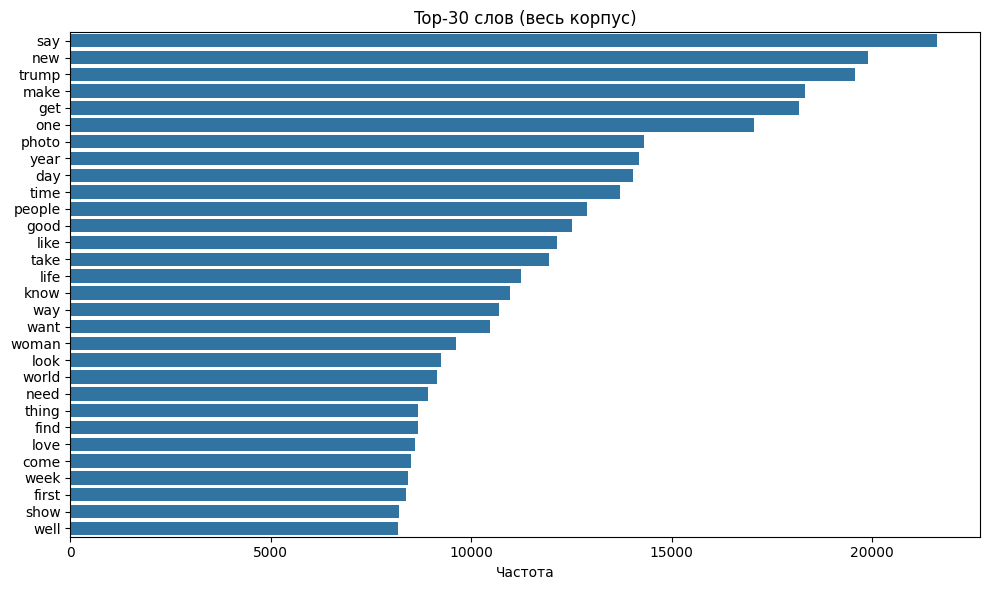

In [21]:
# Bar‑chart TOP‑N слов

import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=freq_all.values, y=freq_all.index, orient="h")
plt.title("Top‑30 слов (весь корпус)")
plt.xlabel("Частота"); plt.ylabel("")
plt.tight_layout(); plt.show()

• Частотный ряд подтверждает облако: после «большой семёрки» частоты резко падают.

• good, like, time, life — слова общего характера.

In [22]:
# Heatmap «слово × месяц»
keywords = ["covid", "election", "china", "gun", "abortion", "inflation", "well", "hugs"]
df["month"] = df["date"].dt.to_period("M").astype(str)

In [23]:
def contains_word(text, word):
    return word in text

heat = (
    df[["month","tokens"]]
      .assign(**{w: df["tokens"].apply(lambda x, w=w: w in x).astype(int)
                 for w in keywords})
      .groupby("month")[keywords].sum()
)

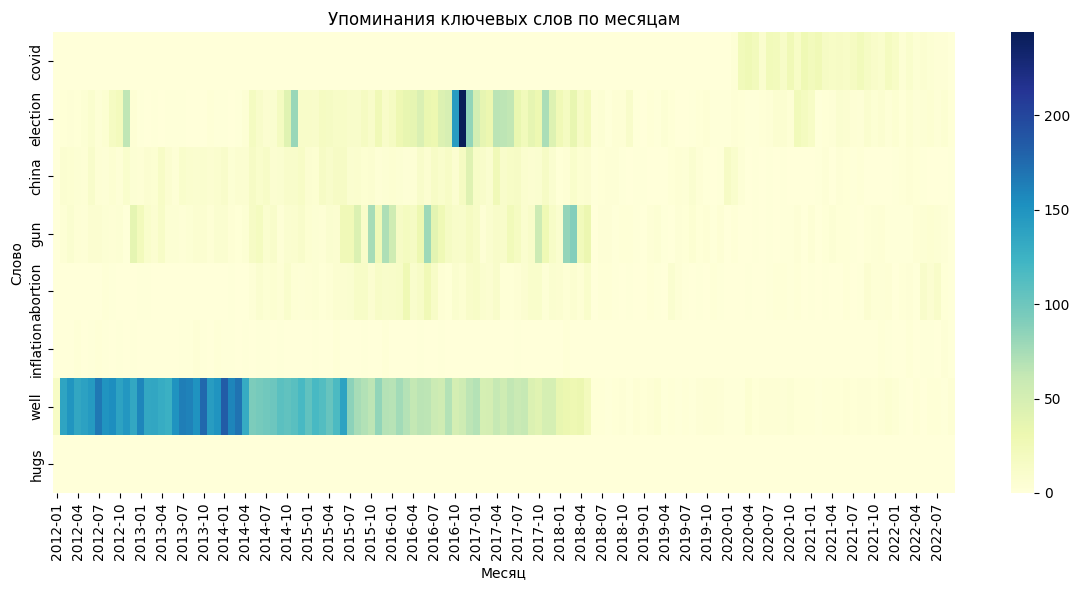

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(heat.T, cmap="YlGnBu")
plt.title("Упоминания ключевых слов по месяцам")
plt.xlabel("Месяц"); plt.ylabel("Слово")
plt.tight_layout(); plt.show()

• election & trump — чёткие пики 2016 г. (президентские выборы) и уменьшение после 2021 г.

• covid появляется только c 2020‑01, максимум — середина 2020 г.

• gun имеет периодические всплески → корреляция с масштабными происшествиями.

• inflation, abortion — редкие, но ускоряются к 2022 г.

• well («заглушка» из выражений well‑being/“well”) держится на высоком уровне всегда → неинформативно.

In [26]:
# Интерактивный bubble‑chart
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px

vec = TfidfVectorizer(max_features=20_000, ngram_range=(1,1))
X   = vec.fit_transform(df["text"])

idf  = vec.idf_
vocs = np.array(vec.get_feature_names_out())

top  = idf.argsort()[:200]

freq_series = tokens.value_counts()

data = pd.DataFrame({
    "word": vocs[top],
    "idf" : idf[top],
    "freq": freq_series.reindex(vocs[top]).fillna(0).values   # ← ключевая правка
})

fig = px.scatter(data, x="idf", y="freq", text="word",
                 size="freq", log_y=True, height=600,
                 title="TF‑IDF vs Frequency (пузырь = частота)")
fig.show()

• Две плотные «тучи»:

  — слева‑вверху (низкий idf, высокая freq) — общеупотребительные слова (say, new, people).

  — справа‑ниже (высокий idf, средняя freq) — более “специфичные” (women, children, photos, covid, shooting).

• Самые информативные токены — с idf ≈ 4‑5 и freq 200‑2 000 (редкие, но не уникальные).

# Числовые признаки, train / test split и базовый набор моделей

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [25]:
df["clean"] = df["tokens"].str.join(" ")

tfidf = TfidfVectorizer(
        tokenizer=str.split,
        ngram_range=(1, 2),
        max_features=80_000,
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
        norm="l2"
)

X = tfidf.fit_transform(df["clean"])
y = df["category"].values

print("TF-IDF shape:", X.shape)
joblib.dump(tfidf, "data/tfidf_80k.pkl")

/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF shape: (209527, 80000)


['data/tfidf_80k.pkl']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (167621, 80000) Test: (41906, 80000)


In [27]:
from sklearn.linear_model import (LogisticRegression, SGDClassifier,
                                  RidgeClassifier, PassiveAggressiveClassifier)
from sklearn.svm           import LinearSVC
from sklearn.naive_bayes   import ComplementNB
from sklearn.dummy         import DummyClassifier
from sklearn.metrics        import accuracy_score, f1_score
import time

In [33]:
# оставляем ровно N_PER_CLASS примеров в каждой категории
RND_SEED      = 42
N_PER_CLASS   = 1_000

np.random.seed(RND_SEED)
df_small = (
    df.groupby("category", group_keys=False)
      .apply(lambda g: g.sample(min(len(g), N_PER_CLASS),
                                random_state=RND_SEED))
      .reset_index(drop=True)
)

print(f"↓ было: {len(df):,}  ➜  стало: {len(df_small):,} текстов")
X_small = df_small["text"].values
y_small = df_small["category"].values

↓ было: 209,527  ➜  стало: 42,000 текстов


/var/folders/76/1xt6qg8s6t52vttr64_3w56w0000gn/T/ipykernel_35356/496231927.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), N_PER_CLASS),


In [34]:
# Базовые модели (7 шт.)
models = {
    "LogReg"  : LogisticRegression(max_iter=5000, solver="saga",
                                   C=3, penalty="l2", n_jobs=1,
                                   class_weight="balanced"),
    "LinearSVC": LinearSVC(C=2, class_weight="balanced"),
    "SGD"      : SGDClassifier(loss="hinge", alpha=1e-4,
                               max_iter=1000, n_jobs=1,
                               class_weight="balanced"),
    "Ridge"    : RidgeClassifier(alpha=1.0, class_weight="balanced"),
    "Passive"  : PassiveAggressiveClassifier(C=1.0, max_iter=1000,
                                             n_jobs=1, class_weight="balanced"),
    "ComplNB"  : ComplementNB(alpha=1.0),
    "Dummy"    : DummyClassifier(strategy="stratified", random_state=42)
}

In [52]:
tfidf = TfidfVectorizer(max_features=20_000,
                        ngram_range=(1,2),
                        min_df=5,
                        norm="l2")

pipelines = {name: make_pipeline(tfidf, clf) for name, clf in models.items()}

In [54]:
from sklearn.pipeline                import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import train_test_split
from joblib                           import parallel_backend

X_tr, X_te, y_tr, y_te = train_test_split(
        X_small, y_small, test_size=0.20,
        stratify=y_small, random_state=RND_SEED)

results = []
with parallel_backend("threading"):
    for name, pipes in pipelines.items():
        t0 = time.time()
        pipes.fit(X_tr, y_tr)
        pred = pipes.predict(X_te)
        acc  = accuracy_score(y_te, pred)
        f1   = f1_score(y_te, pred, average="macro")
        results.append((name, acc, f1, time.time()-t0))

res_df = (pd.DataFrame(results, columns=["Model","Acc","F1","TrainTime(s)"])
     .sort_values("F1", ascending=False))

/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T


In [42]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND_SEED)

with parallel_backend("threading"):
    for name, pipe in pipelines.items():
        f1s = cross_val_score(pipe, X_small, y_small,
                              cv=cv, scoring="f1_macro", n_jobs=-1)
        print(f"{name:10s} | F1_macro CV: {f1s.mean():.3f} ± {f1s.std():.3f}")

LogReg     | F1_macro CV: 0.472 ± 0.003
LinearSVC  | F1_macro CV: 0.439 ± 0.004
SGD        | F1_macro CV: 0.442 ± 0.005


/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_.T
/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:313: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_

Ridge      | F1_macro CV: 0.463 ± 0.005
Passive    | F1_macro CV: 0.414 ± 0.003
ComplNB    | F1_macro CV: 0.452 ± 0.003
Dummy      | F1_macro CV: 0.023 ± 0.000


In [44]:
# Выбор «лучшей» базовой модели

best_name = res_df.iloc[0]["Model"]
best_clf  = models[best_name]
print("Baseline winner:", best_name)
joblib.dump(best_clf, f"{best_name}_baseline.pkl")

Baseline winner: LogReg


['LogReg_baseline.pkl']

In [62]:
tf = TfidfVectorizer(max_features=10_000, ngram_range=(1,1), min_df=5)
X_small_tf = tf.fit_transform(df_small["text"])
y_small    = df_small["category"]

In [63]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_small_tf, y_small, test_size=0.2, stratify=y_small,
    random_state=RND_SEED
)

In [64]:
# Базовая модель
base_clf = LogisticRegression(
    solver="liblinear",       # быстрее на небольшой выборке
    multi_class="ovr",        # совместимо с liblinear
    max_iter=1000,
    n_jobs=1,
    class_weight="balanced",
    random_state=42
)

In [65]:
from scipy.stats import loguniform

param_dist = {
    "C": loguniform(1e-3, 1e2),   # уже диапазон
}

In [46]:
import os
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
os.environ["PYTHONWARNINGS"] += ",ignore::UserWarning"

In [66]:
from sklearn.model_selection import RandomizedSearchCV

cv   = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
rs   = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=2,
    random_state=42,
    verbose=1
)

rs.fit(X_tr, y_tr)
print("Best params :", rs.best_params_)
print("CV macro-F1 :", rs.best_score_)

best_logreg = rs.best_estimator_

Fitting 2 folds for each of 15 candidates, totalling 30 fits


/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params : {'C': np.float64(3.4702669886504163)}
CV macro-F1 : 0.4506298435497587


In [67]:
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, confusion_matrix
)
import seaborn as sns

In [69]:
pred_test = best_logreg.predict(X_te)

print("Accuracy     :", accuracy_score(y_te, pred_test))
print("macro-F1     :", f1_score(y_te, pred_test, average="macro"))
print("\nReport ↓")
print(classification_report(y_te, pred_test))

Accuracy     : 0.4760714285714286
macro-F1     : 0.47504276045680205

Report ↓
                precision    recall  f1-score   support

          ARTS       0.32      0.24      0.28       200
ARTS & CULTURE       0.44      0.39      0.41       200
  BLACK VOICES       0.43      0.35      0.39       200
      BUSINESS       0.39      0.40      0.39       200
       COLLEGE       0.59      0.56      0.58       200
        COMEDY       0.52      0.46      0.49       200
         CRIME       0.48      0.58      0.52       200
CULTURE & ARTS       0.53      0.51      0.52       200
       DIVORCE       0.77      0.67      0.72       200
     EDUCATION       0.62      0.63      0.62       200
 ENTERTAINMENT       0.35      0.38      0.36       200
   ENVIRONMENT       0.41      0.36      0.38       200
         FIFTY       0.35      0.39      0.37       200
  FOOD & DRINK       0.48      0.53      0.50       200
     GOOD NEWS       0.41      0.47      0.44       200
         GREEN       0.3